<a href="https://colab.research.google.com/github/nielsenreaveley/Projects/blob/main/diabetes_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetes dataset

This is a binary classifcation project. We want to see if people have diabetes or not based on features. 1 indicates the person has diabetes, 0 shows the person does not have diabetes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, RocCurveDisplay, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV


# EDA

In [2]:
df = pd.read_csv("/content/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.shape

(768, 9)

In [4]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

despite the fact there are no missing values, to have an insulin level of 0 is not possible, therefore we'll impute value with zero with the median

In [5]:
df["Insulin"].value_counts()

0      374
105     11
130      9
140      9
120      8
      ... 
73       1
171      1
255      1
52       1
112      1
Name: Insulin, Length: 186, dtype: int64

In [6]:
df["Outcome"].value_counts() # this shows there's a lot more people who don't have diabetes in comparison to those who do, at a approximate ratio of 2:1

0    500
1    268
Name: Outcome, dtype: int64

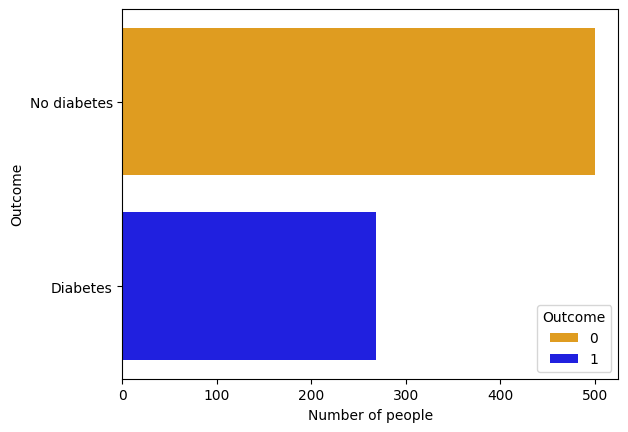

In [7]:
custom_palette = ["orange", "blue"]

sns.countplot(y="Outcome", hue="Outcome", data=df, palette=custom_palette)

plt.xlabel("Number of people")
plt.ylabel("Outcome")
plt.yticks([0,1],["No diabetes", "Diabetes"]);

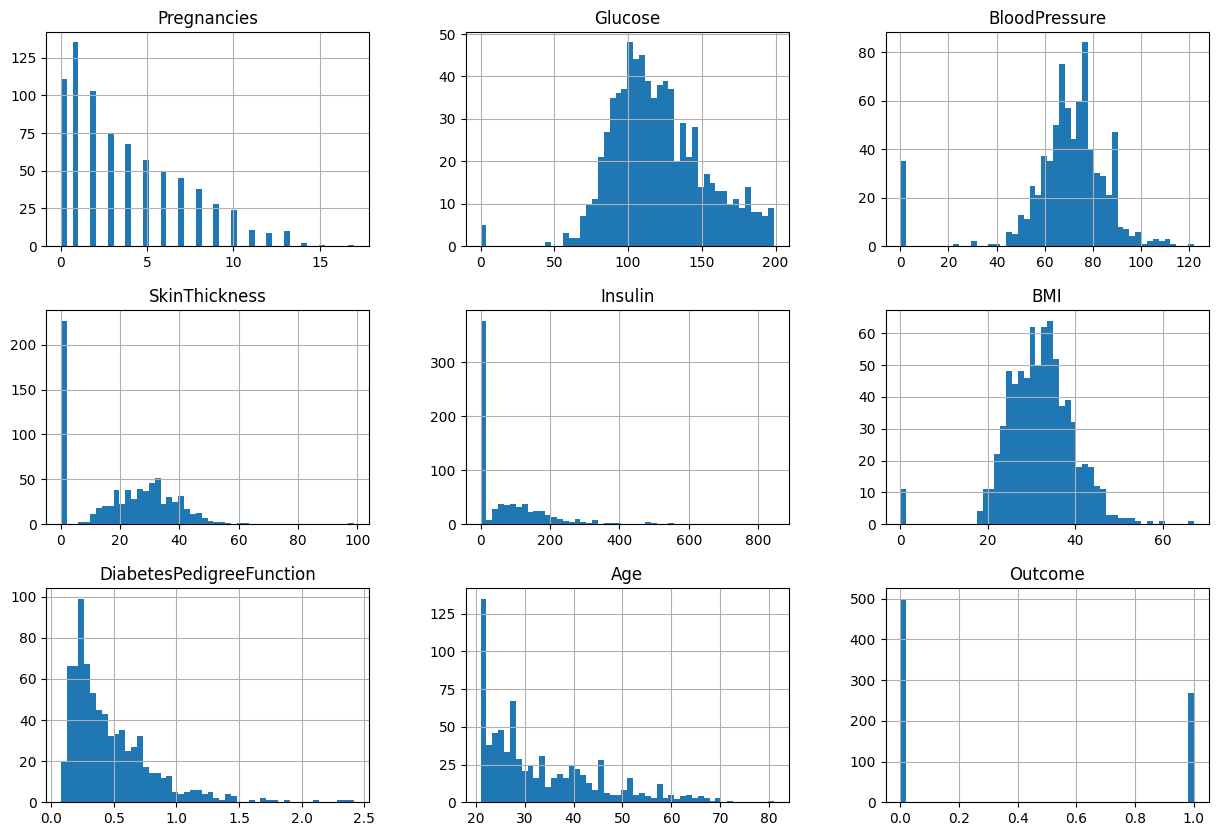

In [8]:
df.hist(bins=50, figsize=(15,10))
plt.show()

# Correlation matrix

In [9]:
df.corr(numeric_only=True) # in our case they are all numeric oclumns but this is to exemplify the faact that we should exclude non-numeric data from corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


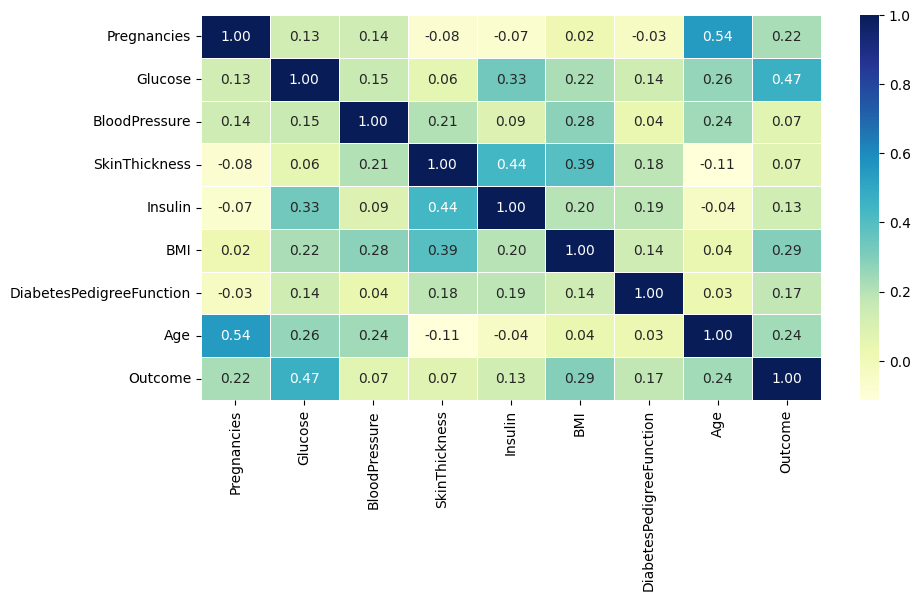

In [10]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(numeric_only=True), annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu")
plt.show()

We can deduce from correlation matrix heatmap, that "Glucose" has the biggest impact on whether someone has diabetes or not. This is because it has a positive correlation with the "Outcome" column, at 0.47, as shown on top right of heatmap.

Another conclusion from the correlation matrix is that there is no massively negative correlations between all the data in the dataframe.

We can see BMI has second biggest impact, at a positive correlation of 0.29.


An easier way to visualise the correlation is to put the correlation matrix in descending order of value, as shown below. Note, to get this table, we single out the "Outcome" column, as oppossed to whole dataframe!

In [11]:
corr_matrix = df.corr()

corr_matrix["Outcome"].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


# Split our data and preprocess

In [12]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

In [13]:
X.shape, y.shape

((768, 8), (768,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [16]:
df.head() # looking to see what preprocessing is necessary, if any

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


we can see from df above, we need to normalise columns

In [17]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [18]:
numeric_columns = df.select_dtypes(include=["int", "float"]).columns.tolist()
numeric_columns.remove("Outcome") # we drop from list as this is target label: can't use .drop here as not available for lists!
numeric_columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [19]:
numeric_features = numeric_columns

numeric_transformer = Pipeline(steps=[
    ("Scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features)
    ]
)

X_train_pp = preprocessor.fit_transform(X_train)
X_test_pp = preprocessor.transform(X_test)

In [20]:
# turn preprocessed data into df
df_train_pp = pd.DataFrame(X_train_pp)
df_train_pp

,0,1,2,3,4,5,6,7
0,-1.126182,2.093753,1.806215,0.272804,-0.696394,0.317015,-0.072750,0.636380
1,-0.831937,-0.968440,-0.383044,-0.160177,-0.176945,-0.857944,2.561314,-0.710990
2,2.110513,-0.566334,-0.070293,1.200619,-0.696394,1.836800,-1.049852,0.720590
3,2.699002,1.134885,2.327467,-1.273555,-0.696394,1.338719,-0.635611,0.889011
4,0.933533,-0.226090,-0.278793,-1.273555,-0.696394,-0.564204,0.866406,0.046906
...,...,...,...,...,...,...,...,...
609,1.227778,0.918366,0.450959,0.705784,1.152493,1.415347,0.183384,0.215327
610,1.816268,1.784441,0.033958,-1.273555,-0.696394,0.419186,-0.815853,0.299537
611,-0.537692,-0.628197,-0.591545,0.891347,0.095986,-1.279397,-0.958150,-0.963621
612,0.639288,-0.597265,0.659460,-1.273555,-0.696394,-0.129980,-0.879096,0.215327


# Train model

In [21]:
log_reg_model = LogisticRegression()
log_reg_cv = LogisticRegressionCV()
decision_tree_model = DecisionTreeClassifier()
random_forest_model = RandomForestClassifier()
gradient_boosting_model = GradientBoostingClassifier()
knn_model = KNeighborsClassifier()
gaussian_nb_model = GaussianNB()

df_shuffled = df.sample(frac=1)

models = {"Logistic Regression": LogisticRegression(),
          "Logistic Regression CV": LogisticRegressionCV(),
          "Decision Tree Classifier": DecisionTreeClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Gradient Boosting Classifier": GradientBoostingClassifier(),
          "KNN": KNeighborsClassifier(),
          "Gaussian": GaussianNB()}


def fit_and_score(models, X_train_pp, X_test_pp, y_train, y_test):
  model_scores = {}
  for name, model in models.items():
    model.fit(X_train_pp, y_train)
    train_score = model.score(X_train_pp, y_train)
    test_score = model.score(X_test_pp, y_test)

    model_scores[name] = {"train score": train_score, "test score": test_score}

    print(f"{name} Training accuracy: {train_score}")
    print(f"{name} Test accuracy: {test_score}")
    print()

  return model_scores


In [22]:

model_scores = fit_and_score(models,
                             X_train_pp,
                             X_test_pp,
                             y_train,
                             y_test)

Logistic Regression Training accuracy: 0.7866449511400652
Logistic Regression Test accuracy: 0.7727272727272727

Logistic Regression CV Training accuracy: 0.7866449511400652
Logistic Regression CV Test accuracy: 0.7727272727272727

Decision Tree Classifier Training accuracy: 1.0
Decision Tree Classifier Test accuracy: 0.7012987012987013

Random Forest Training accuracy: 1.0
Random Forest Test accuracy: 0.7662337662337663

Gradient Boosting Classifier Training accuracy: 0.9185667752442996
Gradient Boosting Classifier Test accuracy: 0.7467532467532467

KNN Training accuracy: 0.8224755700325733
KNN Test accuracy: 0.7467532467532467

Gaussian Training accuracy: 0.762214983713355
Gaussian Test accuracy: 0.7532467532467533



We'll now tune Logistic Regression as it performed best!

In [23]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [24]:
param_grid = [
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

In [25]:
lr_rs = RandomizedSearchCV(LogisticRegression(),
                          param_distributions=param_grid,
                          cv=5,
                          n_iter = 16,
                          verbose=0)

# fit hyperparameter search model for RandomForestClassifier()
lr_rs.fit(X_train_pp, y_train);

In [26]:
lr_rs.score(X_train_pp, y_train)

0.7882736156351792

In [27]:
lr_rs.score(X_test_pp, y_test)

0.7662337662337663

In [29]:
lr_gs = GridSearchCV(LogisticRegression(),
                     param_grid=param_grid,
                     cv=5,
                     verbose=0)

# fit grid hyperparameter search model for RandomForestClassifier
lr_gs.fit(X_train_pp, y_train);

In [30]:
lr_gs.score(X_train_pp, y_train)

0.7785016286644951

In [31]:
lr_gs.score(X_test_pp, y_test)

0.7597402597402597

# Evaluation

In [32]:
y_preds = lr_gs.predict(X_test_pp)

In [33]:
confusion_matrix(y_test, y_preds)

array([[88, 11],
       [26, 29]])

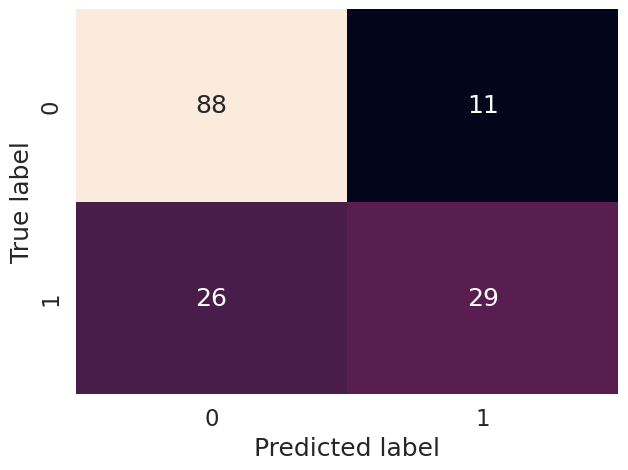

In [34]:
sns.set(font_scale=1.5)  # Increase font size

def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(7, 5))  # Adjust the figure size as needed
    cm = confusion_matrix(y_test, y_preds)  # Calculate confusion matrix
    ax = sns.heatmap(cm,
                     annot=True,  # Annotate the boxes
                     fmt='d',    # Display numbers as integers
                     cbar=False)
    plt.xlabel("Predicted label")  # Predictions go on the x-axis
    plt.ylabel("True label")       # True labels go on the y-axis

plot_conf_mat(y_test, y_preds)

we can see biggest errors our model is making is false negative, with 26! This means our model is predicting 25 people don't have diabetes, who actually do. Especially in a health project, where truth is crucial, we would want to improve this!

<Figure size 3000x1000 with 0 Axes>

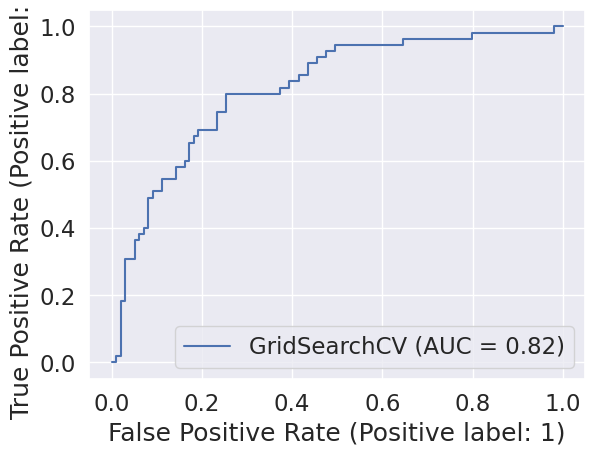

In [35]:
plt.figure(figsize=(30,10))

RocCurveDisplay.from_estimator(estimator=lr_gs,
                               X=X_test_pp,
                               y=y_test);

In [36]:

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83        99
           1       0.72      0.53      0.61        55

    accuracy                           0.76       154
   macro avg       0.75      0.71      0.72       154
weighted avg       0.76      0.76      0.75       154



We have achieved a cross-validated test score of 76% using Logistic Regression.

I did experiment with Under and Over sampling, but didn't help results. However, due to the fact that the class imbalance wasn't extreme, i.e 9 to 1, I felt at this time it wasn't the most important thing.

To further improve, I could tune and cross validate other models that performed well to see if they could outdo Logistic Regression.

I could also do further investigation into the false negatives and how to lower that number.

One last consideration might be revisitng the columns, because EDA wasn't that thorough due to the fact I was focusing on improving my skills in other areas in this project.

By performing further EDA, and revisitng correlation matrix, I may be able to get rid of columns that could potentially harm model performance, especially considering the fact that this dataset is simple!